In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib notebook 

Euler explicite à pas variable
------------

La fonction suivante code un exemple de schéma d'Euler explicite à pas variable : l'erreur commise est estimée à chaque itération et le pas de temps adapté de façon à garder cette erreur en dessous d'un seuil. Le pas reste compris entre dtmin et dtmax fixés par l'utilisateur et sort la solution échantillonnée à dtmax. La méthode d'estimation de l'erreur locale utilisée ici est justifiée dans le poly.

In [6]:
def solve_ivp_euler_explicit_variable_step(f, t0, x0, t_f, dtmin = 1e-16, dtmax = 0.01, atol = 1e-6):
    dt = dtmax/10; # initial integration step
    ts, xs = [t0], [x0]  # storage variables
    t = t0
    ti = 0  # internal time keeping track of time since latest storage point : must remain below dtmax
    x = x0
    while ts[-1] < t_f:
        while ti < dtmax:
            t_next, ti_next, x_next = t + dt, ti + dt, x + dt * f(x)
            x_back = x_next - dt * f(x_next)
            ratio_abs_error = atol / (np.linalg.norm(x_back-x)/2)
            dt = 0.9 * dt * np.sqrt(ratio_abs_error)
            if dt < dtmin:
                raise ValueError("Time step below minimum")
            elif dt > dtmax/2:
                dt = dtmax/2
            t, ti, x = t_next, ti_next, x_next
        dt2DT = dtmax - ti # time left to dtmax
        t_next, ti_next, x_next = t + dt2DT, 0, x + dt2DT * f(x)
        ts = np.vstack([ts,t_next])
        xs = np.vstack([xs,x_next])
        t, ti, x = t_next, ti_next, x_next
    return (ts, xs.T)


Par exemple, sur un oscillateur, le pas de temps "interne" s'adapte automatiquement à la pulsation $\omega$. Notons que la solution en sortie est toujours échantillonnées à dtmax, donc il faut diminuer ce paramètre si l'on veut plus de précision de visualisation.

<IPython.core.display.Javascript object>


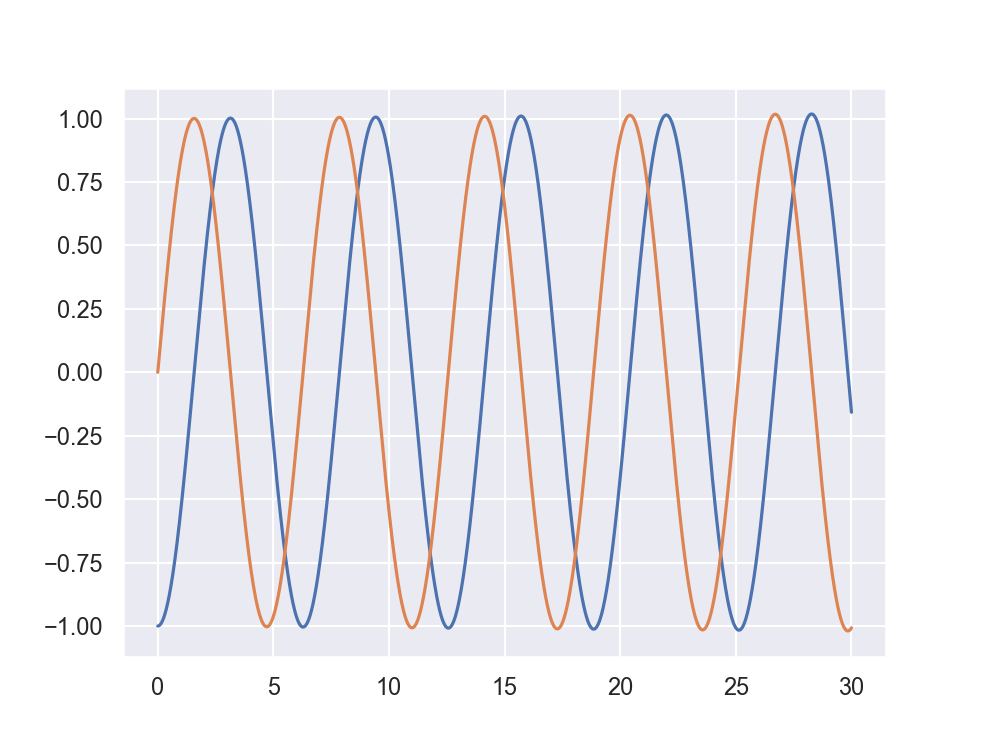

<IPython.core.display.Javascript object>


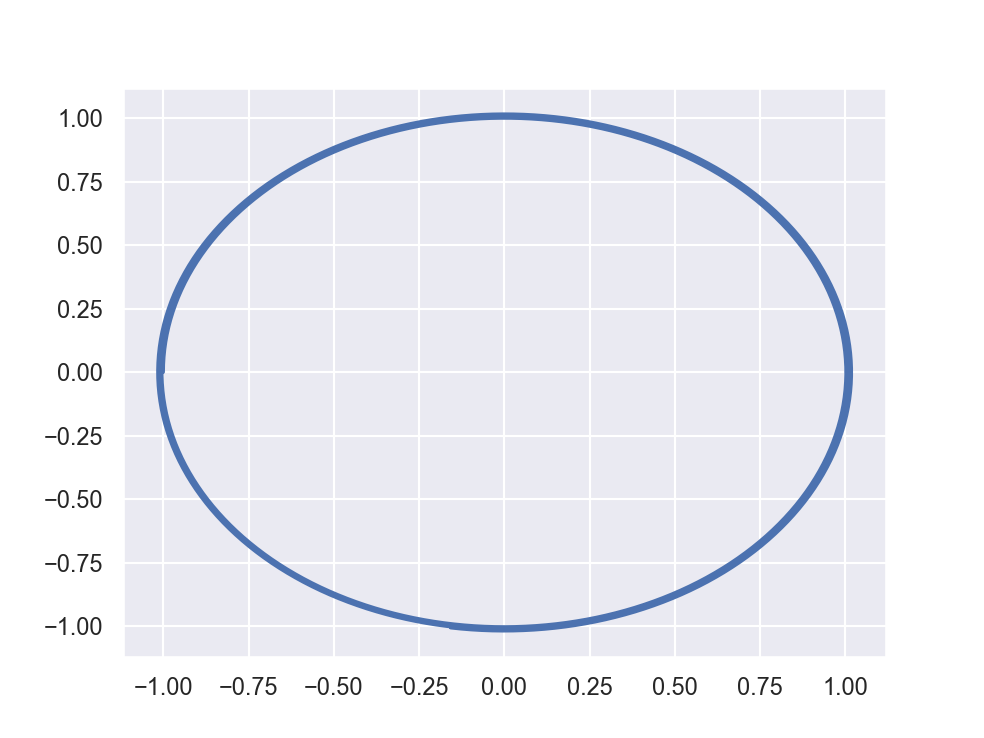

In [6]:
# Oscillateur 

omega = 1

def f(xy):
    x, y = xy
    return np.array([y, -omega*x])

t0, tf, x0 = 0.0, 30.0, np.array([-1.0, 0.0])

t, x = solve_ivp_euler_explicit_variable_step(f, t0, x0, tf)

plt.figure()
plt.plot(t, x[0])
plt.plot(t, x[1])
plt.grid(True)

plt.figure()
plt.plot(x[0],x[1])

On constate cependant que les solutions ne suivent pas une ellipse parfaite car l'énergie n'est pas conservée par l'algorithme. Pour ce type de système conservatif, il faudrait en fait un schéma symplectique. Voir plus bas.

# Système raide 

Les systèmes raides désignent des systèmes comprenant des dynamiques aux constantes de temps très différentes. Dans ce cas, le pas nécessaire pour simuler avec précision les dynamiques très rapides est si petit, qu'il est alors impossible de simuler assez longtemps pour observer les parties lentes. La particularité de ces systèmes est que cette décroissance du pas apparaît alors que la solution est parfaitement régulière, et non pas proche de singularités.

La coexistence de dynamiques très lentes à très rapides apparaît typiqument en cinétique chimique, par exemple la réaction de Robertson :
\begin{align*}
A & \stackrel{0.04}{\longrightarrow}  B \quad \text{(lente)} \\ 
B + B & \stackrel{3 \times 10^7}{\longrightarrow}  B + C \quad \text{(très rapide)}  \\
B + C & \stackrel{10^4}{\longrightarrow}  A + C  \quad \text{(rapide)} 
\end{align*}
modélisée par 
\begin{align*}
\dot{x}_a &= -0.04 x_b + 10^4 x_bx_c \\
\dot{x}_b &= 0.04 x_a - 10^4 x_bx_c - 3\times 10^7 x_b^2\\
\dot{x}_c &= 3\times 10^7 x_b^2
\end{align*}

Lorsqu'on applique le schéma d'Euler explicite à pas variable, le compromis précision/pas de temps devient impossible. 

In [4]:

def f(xabc):
    xa, xb, xc = xabc
    return np.array([-0.04 * xb + 1e4 * xb * xc, 0.04 * xa - 1e4 * xb * xc - 3e7 * xb**2,  3e7 * xb**2])

t0, tf, x0 = 0.0, 5.0, np.array([1.0, 0.0, 0.0])

t, x = solve_ivp_euler_explicit_variable_step(f, t0, x0, tf, dtmin = 1e-20, atol = 1)

plt.figure()
plt.plot(t, x[0])
plt.plot(t, x[1])
plt.plot(t, x[2])
plt.grid(True)

ValueError: Time step below minimum

Système hamiltonien 
=====================

Voir exercice "Euler Symplectique". On cherche à simuler
\begin{align*}
\dot{q} &= \nabla_p H(q,p) \\
\dot{p} &= - \nabla_q H(q,p)
\end{align*}
où $(q,p)\in \mathbb{R}^N \times \mathbb{R}^N$ et $H$ est le hamiltonien conservé le long des trajectoires. $N$ est typiquement le nombre de corps/particules, $q$ contient leurs positions généralisées et $p$ leur quantité de mouvement.

Par exemple, pour un oscillateur harmonique simple, $N=1$, et $H$ est l'énergie mécanique du type
$$
H(q,p) = \frac{1}{2m}p^2 + \frac{1}{2} k q^2
$$
ce qui donne
\begin{align*}
\dot{q} &= \frac{1}{m}p \\
\dot{p} &= - k q
\end{align*}
ou de manière équivalente, si on considère la vitesse $v$ au lieu de la quantité de mouvement $p=mv$,
\begin{align*}
\dot{q} &= v \\
\dot{v} &= - \frac{k}{m} q
\end{align*}

In [7]:
m = 1.0
k = 1.0
q0 = 1.0
p0 = m*0.0
t0, tf, dt = 0.0 , 50.0, 0.01

In [8]:
def solve_ivp_euler_symplectic(fp, fq, t0, q0, p0, dt, tf):
    ts, qs, ps = [t0], [q0], [p0]
    while ts[-1] < tf:
        t, q, p = ts[-1], qs[-1], ps[-1]
        t_next, q_next = t + dt, q + dt*fq(p)
        p_next = p + dt*fp(q_next)
        ts = np.vstack([ts,t_next])
        qs = np.vstack([qs,q_next])
        ps = np.vstack([ps,p_next])
    return (ts, qs.T, ps.T)

In [9]:
def fq(p):
    return 1/m*p

def fp(q):
    return -k*q

def fun(qp):
    q, p = qp
    return np.array([fq(p),fp(q)])

<IPython.core.display.Javascript object>


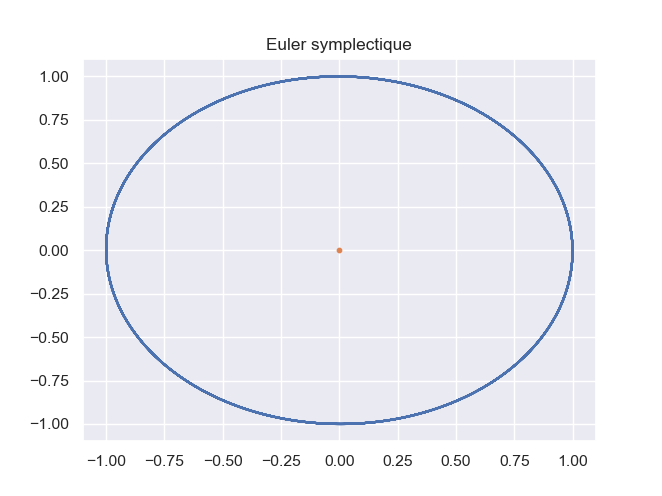

<IPython.core.display.Javascript object>


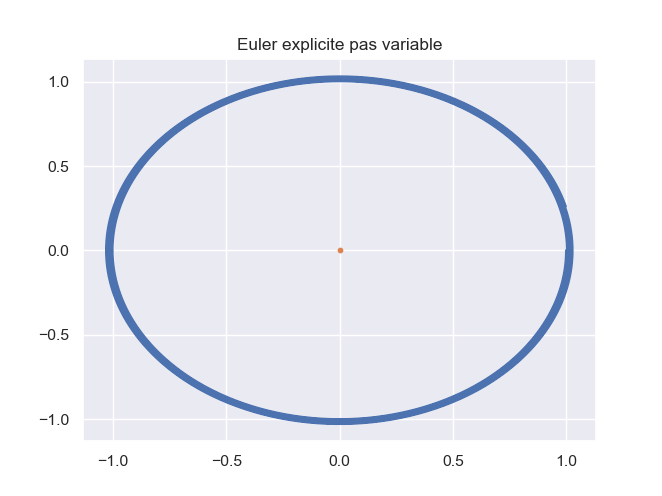

Text(0.5, 1.0, 'Euler explicite pas variable')

In [24]:
t, q, p = solve_ivp_euler_symplectic(fp, fq, t0, q0, p0, dt, tf)

t, qp = solve_ivp_euler_explicit_variable_step(fun, t0, np.array([q0,p0]), tf)

plt.figure()
plt.plot(p[0],q[0])
plt.plot([0.0],[0.0],'.')
plt.grid(True)
plt.title('Euler symplectique')

plt.figure()
plt.plot(qp[0],qp[1])
plt.plot([0.0],[0.0],'.')
plt.grid(True)
plt.title('Euler explicite pas variable')

